In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import modin.pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import warnings

from datetime import datetime, timedelta
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from torch import flatten, nn
from torch.nn import Conv2d, Linear, LogSoftmax, MaxPool2d, Module, ReLU
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler

In [ ]:
warnings.filterwarnings("ignore")
torch.set_num_threads(11)
sns.set(rc={'figure.figsize':(16,5)})
pd.set_option('display.max_columns', None)
PATH = 'C:/Users/randa/Downloads/'

# Data Preparation

In [ ]:
# file = 'final1strun_v1_without_NA_2dp.csv'
file = 'final1strun_v3_without_NA_2dp.csv'
# file = 'cleaned_final1strun_v3_without_NA_2dp.csv'
# file = '2ndRun.csv'
# file = '3rdRun.csv'

In [ ]:
data = pd.read_csv(file)
posts = ['POST'+str(i+1) for i in range(int(data.shape[1])-6)]
col_names = ['Asset', 'Time', 'Identifier'] + posts + ['X_Coord', 'Y_Coord']
data = pd.read_csv(file, header=0, names=col_names)
data.head(20)

,Asset,Time,Identifier,POST1,POST2,POST3,POST4,POST5,POST6,POST7,POST8,X_Coord,Y_Coord
0,cd:57,0,0,-73.0,-72.67,-75.0,-72.0,-71.67,-73.75,-72.67,-77.0,7.0,4.0
2,cd:57,0,2,-73.0,-72.67,-75.0,-72.0,-71.67,-73.75,-72.00,-77.0,7.0,4.0
4,cd:57,0,4,-73.0,-72.67,-75.0,-72.0,-71.67,-75.00,-72.67,-77.0,7.0,4.0
6,cd:57,0,6,-73.0,-72.67,-75.0,-72.0,-71.67,-75.00,-72.00,-77.0,7.0,4.0
8,cd:57,0,8,-73.0,-72.67,-75.0,-72.0,-69.00,-73.75,-72.67,-77.0,7.0,4.0
10,cd:57,0,10,-73.0,-72.67,-75.0,-72.0,-69.00,-73.75,-72.00,-77.0,7.0,4.0
12,cd:57,0,12,-73.0,-72.67,-75.0,-72.0,-69.00,-75.00,-72.67,-77.0,7.0,4.0
14,cd:57,0,14,-73.0,-72.67,-75.0,-72.0,-69.00,-75.00,-72.00,-77.0,7.0,4.0
64,cd:57,0,64,-73.0,-73.00,-75.0,-72.0,-71.67,-73.75,-72.67,-77.0,7.0,4.0
66,cd:57,0,66,-73.0,-73.00,-75.0,-72.0,-71.67,-73.75,-72.00,-77.0,7.0,4.0


In [ ]:
data['XY'] = data.iloc[:,11:13].apply(lambda x: ','.join(x.astype(int).astype(str)), axis=1)
data['XY'] = data['XY'].apply(lambda x: int(x.split(',')[0])*8 + int(x.split(',')[1]))
data.iloc[:,3:11] = data.iloc[:,3:11].replace([100], -100)
data.head()

,Asset,Time,Identifier,POST1,POST2,POST3,POST4,POST5,POST6,POST7,POST8,X_Coord,Y_Coord,XY
0,cd:57,0,0,-73.0,-72.67,-75.0,-72.0,-71.67,-73.75,-72.67,-77.0,7.0,4.0,"7,4"
2,cd:57,0,2,-73.0,-72.67,-75.0,-72.0,-71.67,-73.75,-72.00,-77.0,7.0,4.0,"7,4"
4,cd:57,0,4,-73.0,-72.67,-75.0,-72.0,-71.67,-75.00,-72.67,-77.0,7.0,4.0,"7,4"
6,cd:57,0,6,-73.0,-72.67,-75.0,-72.0,-71.67,-75.00,-72.00,-77.0,7.0,4.0,"7,4"
8,cd:57,0,8,-73.0,-72.67,-75.0,-72.0,-69.00,-73.75,-72.67,-77.0,7.0,4.0,"7,4"


In [ ]:
cdata = {}
for x in data['Asset'].unique():
    cdata[x] = data[data['Asset'] == x].sort_values(by='Time').reset_index(drop=True)

In [ ]:
# median for each asset/listening post pair is made to fill anomalous data 
# also used for possible visualisation some time down the road
median = {}
for asset in cdata.keys():
    median[asset] = {}
    for timestamp in cdata[asset]['Time'].unique():
        median[asset][timestamp] = {}
        view = cdata[asset][cdata[asset]['Time'] == timestamp]
        for post, value in zip(view.describe().loc[['50%'],posts].columns, view.describe().loc[['50%'],posts].values[0]):
            median[asset][timestamp][post] = value

In [ ]:
### Incorporate RSSI reading @ 1m for each asset/listening post pair (TODO)

In [ ]:
### Get weighted-average values from median
weighted_average = {} 
for asset, data in median.items():
    weighted_average[asset] = {}
    past_2, past_1 = list(median[asset][0].values()), list(median[asset][0].values())
    for k, v in data.items():
        weighted_average[asset][k] = {}
        current = list(v.values())
        post_num = 1
        for x in np.mean(np.array([past_2, past_1, current]), axis=0):
            weighted_average[asset][k]['POST'+str(post_num)] = x
            post_num += 1
        past_2, past_1 = past_1, current

In [ ]:
for asset in weighted_average.keys():
    for x in posts:
        cdata[asset]['MAvg_'+x] = 0
for asset in cdata.keys():
    for timestamp, posts in weighted_average[asset].items():
        for post, RSSI in posts.items():
            cdata[asset].loc[cdata[asset]['Time'] == timestamp, ['MAvg_'+post]] = RSSI

In [ ]:
### normalise to range of 0-1, reason against using MinMaxScaler shown below
for asset in cdata.keys():
    for post in posts:
        cdata[asset][post] = (cdata[asset][post]+40)/-60
        cdata[asset][post] = np.maximum(cdata[asset][post], 0)
        cdata[asset]['MAvg_'+post] = (cdata[asset]['MAvg_'+post]+40)/-60
        cdata[asset]['MAvg_'+post] = np.maximum(cdata[asset]['MAvg_'+post], 0)

In [ ]:
data = pd.concat([i for i in cdata.values()]).sample(frac=1).reset_index(drop=True)
data

,Asset,Time,Identifier,POST1,POST2,POST3,POST4,POST5,POST6,POST7,POST8,X_Coord,Y_Coord,XY,WAvg_POST1,WAvg_POST2,WAvg_POST3,WAvg_POST4,WAvg_POST5,WAvg_POST6,WAvg_POST7,WAvg_POST8
0,d1:dc,5143,44,0.488833,0.483333,0.350000,0.433333,0.483333,0.516667,0.575000,0.566667,5.0,3.0,"5,3",0.470361,0.483333,0.352083,0.466667,0.500472,0.504611,0.569444,0.566667
1,31:ef,3764,4,0.616667,0.333333,0.533333,0.350000,0.583333,0.458333,0.600000,0.605500,5.0,2.0,"5,2",0.622222,0.333333,0.533333,0.350000,0.590750,0.481944,0.600000,0.604611
2,cd:57,3743,81,0.566667,0.316667,0.487500,0.483333,0.541667,0.608333,0.500000,0.508333,5.0,2.0,"5,2",0.550000,0.403694,0.461806,0.406111,0.491667,0.534278,0.514806,0.536111
3,ed:11,2548,128,0.516667,0.555500,0.350000,0.458333,0.383333,0.450000,0.408333,0.522167,3.0,5.0,"3,5",0.519417,0.569417,0.338889,0.477778,0.364833,0.456944,0.400694,0.496278
4,cd:57,187,217,0.483333,0.500000,0.483333,0.516667,0.308333,0.516667,0.433333,0.550000,5.0,4.0,"5,4",0.483333,0.524556,0.451833,0.539806,0.287500,0.484250,0.487028,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149089,cd:57,4021,24,0.562500,0.283333,0.500000,0.291667,0.616667,0.450000,0.500000,0.605500,6.0,0.0,"6,0",0.556944,0.293528,0.505556,0.316194,0.603694,0.504167,0.511111,0.586333
149090,cd:57,1773,97,0.433333,0.475000,0.466667,0.543333,0.522167,0.466667,0.287500,0.550000,1.0,5.0,"1,5",0.432222,0.557639,0.544917,0.534444,0.495361,0.420139,0.320694,0.521750
149091,d1:dc,3670,9,0.533333,0.312500,0.561167,0.416667,0.516667,0.500000,0.494500,0.666667,5.0,0.0,"5,0",0.533333,0.320139,0.601861,0.485194,0.514806,0.480556,0.494222,0.602778
149092,d1:dc,3045,42,0.566667,0.541667,0.441667,0.500000,0.500000,0.475000,0.525000,0.516667,4.0,3.0,"4,3",0.566667,0.530556,0.447917,0.500000,0.513917,0.464583,0.552083,0.538889


In [ ]:
for x,y in cdata.items():
    print(y['XY'].unique())

['7,4' '7,5' '6,6' '5,6' '5,4' '4,4' '4,3' '4,2' '4,1' '4,0' '3,0' '2,0'
 '0,0' '0,1' '1,0' '3,1' '2,1' '1,1' '1,2' '0,2' '0,3' '1,3' '1,4' '2,4'
 '2,3' '2,2' '0,4' '1,5' '0,5' '0,6' '1,6' '2,6' '1,7' '0,7' '2,7' '3,7'
 '4,7' '5,7' '4,6' '3,6' '3,5' '2,5' '3,4' '4,5' '3,3' '3,2' '5,0' '5,1'
 '5,2' '5,3' '6,1' '6,0' '7,0' '7,1' '7,2' '7,3' '6,2' '6,3' '6,4' '5,5'
 '6,5' '7,6' '7,7' '6,7']
['7,4' '7,5' '6,6' '5,6' '5,4' '4,4' '4,3' '4,2' '4,1' '4,0' '3,0' '2,0'
 '0,0' '0,1' '1,0' '3,1' '2,1' '1,1' '1,2' '0,2' '0,3' '1,3' '1,4' '2,4'
 '2,3' '2,2' '0,4' '1,5' '0,5' '0,6' '1,6' '2,6' '1,7' '0,7' '2,7' '3,7'
 '4,7' '5,7' '4,6' '3,6' '3,5' '2,5' '3,4' '4,5' '3,3' '3,2' '5,0' '5,1'
 '5,2' '5,3' '6,1' '6,0' '7,0' '7,1' '7,2' '7,3' '6,2' '6,3' '6,4' '5,5'
 '6,5' '7,6' '7,7' '6,7']
['7,4' '7,5' '6,6' '5,6' '5,4' '4,4' '4,3' '4,2' '4,1' '4,0' '3,0' '2,0'
 '0,0' '0,1' '1,0' '3,1' '2,1' '1,1' '1,2' '0,2' '0,3' '1,3' '1,4' '2,4'
 '2,3' '2,2' '0,4' '1,5' '0,5' '0,6' '1,6' '2,6' '1,7' '0,7' '2,7' '3,7'

In [ ]:
# data.to_csv('cleaned_final1strun_v3_without_NA_2dp.csv')

In [ ]:
data = pd.read_csv('cleaned_final1strun_v3_without_NA_2dp.csv', index_col=0)
data['XY'] = data['XY'].apply(lambda x: int(x.split(',')[0])*8 + int(x.split(',')[1]))
data

,Asset,Time,Identifier,POST1,POST2,POST3,POST4,POST5,POST6,POST7,POST8,X_Coord,Y_Coord,XY,WAvg_POST1,WAvg_POST2,WAvg_POST3,WAvg_POST4,WAvg_POST5,WAvg_POST6,WAvg_POST7,WAvg_POST8
0,d1:dc,5143,44,0.488833,0.483333,0.350000,0.433333,0.483333,0.516667,0.575000,0.566667,5.0,3.0,43,0.470361,0.483333,0.352083,0.466667,0.500472,0.504611,0.569444,0.566667
1,31:ef,3764,4,0.616667,0.333333,0.533333,0.350000,0.583333,0.458333,0.600000,0.605500,5.0,2.0,42,0.622222,0.333333,0.533333,0.350000,0.590750,0.481944,0.600000,0.604611
2,cd:57,3743,81,0.566667,0.316667,0.487500,0.483333,0.541667,0.608333,0.500000,0.508333,5.0,2.0,42,0.550000,0.403694,0.461806,0.406111,0.491667,0.534278,0.514806,0.536111
3,ed:11,2548,128,0.516667,0.555500,0.350000,0.458333,0.383333,0.450000,0.408333,0.522167,3.0,5.0,29,0.519417,0.569417,0.338889,0.477778,0.364833,0.456944,0.400694,0.496278
4,cd:57,187,217,0.483333,0.500000,0.483333,0.516667,0.308333,0.516667,0.433333,0.550000,5.0,4.0,44,0.483333,0.524556,0.451833,0.539806,0.287500,0.484250,0.487028,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149089,cd:57,4021,24,0.562500,0.283333,0.500000,0.291667,0.616667,0.450000,0.500000,0.605500,6.0,0.0,48,0.556944,0.293528,0.505556,0.316194,0.603694,0.504167,0.511111,0.586333
149090,cd:57,1773,97,0.433333,0.475000,0.466667,0.543333,0.522167,0.466667,0.287500,0.550000,1.0,5.0,13,0.432222,0.557639,0.544917,0.534444,0.495361,0.420139,0.320694,0.521750
149091,d1:dc,3670,9,0.533333,0.312500,0.561167,0.416667,0.516667,0.500000,0.494500,0.666667,5.0,0.0,40,0.533333,0.320139,0.601861,0.485194,0.514806,0.480556,0.494222,0.602778
149092,d1:dc,3045,42,0.566667,0.541667,0.441667,0.500000,0.500000,0.475000,0.525000,0.516667,4.0,3.0,35,0.566667,0.530556,0.447917,0.500000,0.513917,0.464583,0.552083,0.538889


In [ ]:
data.dtypes

Asset          object
Time            int64
Identifier      int64
POST1         float64
POST2         float64
POST3         float64
POST4         float64
POST5         float64
POST6         float64
POST7         float64
POST8         float64
X_Coord       float64
Y_Coord       float64
XY             object
WAvg_POST1    float64
WAvg_POST2    float64
WAvg_POST3    float64
WAvg_POST4    float64
WAvg_POST5    float64
WAvg_POST6    float64
WAvg_POST7    float64
WAvg_POST8    float64
dtype: object

In [ ]:
mean_distances = []

## ANN Categorical Models

In [ ]:
# data cleaning for relevant data and obtain validation set
cleaned = data.drop(['Asset', 'X_Coord', 'Y_Coord', 'Time', 'Identifier'], axis=1)

X = cleaned.drop('XY', axis=1).values
y = cleaned['XY'].values

X, X_val, y, y_val = train_test_split(X, y, test_size=0.05, random_state=200)

X_val = X_val.astype(np.float)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

#### As data imbalance is present as shown in the histogram below, stratified k-fold was chosen to split the train-test sets

<AxesSubplot:ylabel='count'>

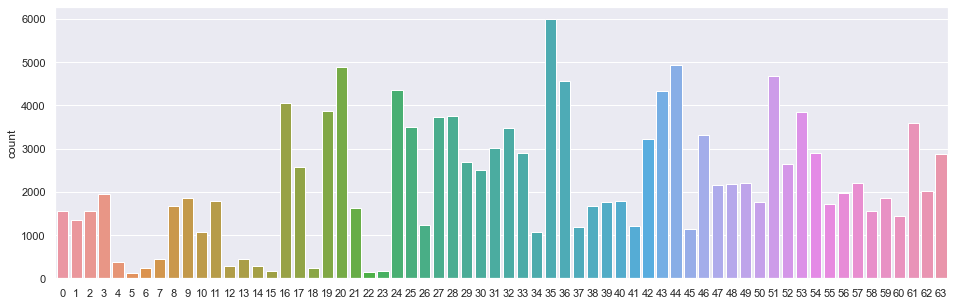

In [ ]:
sns.countplot(y)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
kf.get_n_splits(X)

train_test_datasets = {'train': {'X': {},'y': {}}, 'test': {'X': {},'y': {}}}

for i, (train_index, test_index) in enumerate(kf.split(X,y), 1):
    train_test_datasets['train']['X'][str(i)] = X[train_index]
    train_test_datasets['test']['X'][str(i)] = X[test_index]
    train_test_datasets['train']['y'][str(i)] = y[train_index]
    train_test_datasets['test']['y'][str(i)] = y[test_index]

### Artificial Neural Network (Categorical)

#### Although not shown in this Jupyter notebook, ReLU activation function was tested and proved to be insufficient compared to SiLU and GELU at various depths of Neural Network

In [ ]:
X_train, X_test, y_train, y_test = train_test_datasets['train']['X']['1'], train_test_datasets['test']['X']['1'], train_test_datasets['train']['y']['1'], train_test_datasets['test']['y']['1']

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=64, out_features=192)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(in_features=192, out_features=256)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(in_features=256, out_features=192)
        self.output = nn.Linear(in_features=192, out_features=64)
 
    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = self.dropout1(x)
        x = F.silu(self.fc2(x))
        x = self.dropout2(x)
        x = F.silu(self.fc3(x))
        x = self.dropout3(x)
        x = F.silu(self.fc4(x))
        x = self.output(x)
        return x
    
model = ANN()

In [ ]:
EPOCHS = 1500
L_R = 5e-3

In [ ]:
criterion = nn.CrossEntropyLoss() # choose this if classification
optimizer = torch.optim.Adam(model.parameters(), lr=L_R, weight_decay=1e-5)

In [ ]:
loss_arr = []
loss_arr_test = []
last_loss = 100
patience = 8
trigger_times = 0
best_model = model
best_loss = 999

for i in range(0, EPOCHS+1):  
    y_pred = model.forward(X_train)
    
    loss_train = criterion(y_pred, y_train)
    loss_arr.append(loss_train.item())
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model.forward(X_test)
    loss = criterion(y_pred, y_test)
    loss_arr_test += [float(loss)]
    if loss_arr_test[-1] < best_loss:
        best_loss = loss_arr_test[-1]
        best_model = model
 
    if i%100 == 0:
        print(f'Epoch: {i} Train Loss: {loss_train} Test Loss: {loss_arr_test[-1]}')
    
    if loss > last_loss:
        trigger_times += 1

        if trigger_times > patience:
            print('Early stop!')
            break
    else:
        trigger_times = 0

    last_loss = loss

Epoch: 0 Train Loss: 4.165938854217529 Test Loss: 4.141322612762451
Epoch: 100 Train Loss: 2.5535638332366943 Test Loss: 2.5515544414520264
Epoch: 200 Train Loss: 1.5077276229858398 Test Loss: 1.49994957447052
Epoch: 300 Train Loss: 0.9080696105957031 Test Loss: 0.9237719178199768
Epoch: 400 Train Loss: 0.6962059140205383 Test Loss: 0.7209253907203674
Epoch: 500 Train Loss: 0.5929177403450012 Test Loss: 0.6263670921325684
Epoch: 600 Train Loss: 0.5195550918579102 Test Loss: 0.5418746471405029
Epoch: 700 Train Loss: 0.47550520300865173 Test Loss: 0.4955404996871948
Epoch: 800 Train Loss: 0.4426427483558655 Test Loss: 0.4714311361312866
Epoch: 900 Train Loss: 0.41441264748573303 Test Loss: 0.44444721937179565
Epoch: 1000 Train Loss: 0.39163127541542053 Test Loss: 0.4174177348613739
Epoch: 1100 Train Loss: 0.39766860008239746 Test Loss: 0.41226205229759216
Epoch: 1200 Train Loss: 0.36523255705833435 Test Loss: 0.3964521884918213
Epoch: 1300 Train Loss: 0.3532438576221466 Test Loss: 0.3796

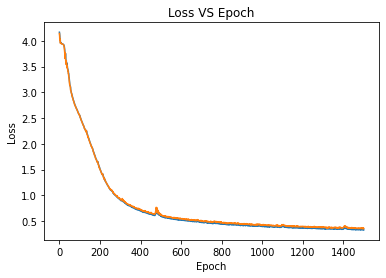

In [ ]:
plt.title('Loss VS Epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)
plt.plot(loss_arr_test)

In [ ]:
model = best_model

In [ ]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_pred = model.forward(val)
        preds.append(y_pred.argmax().item())

In [ ]:
results1 = pd.DataFrame({'yActual': y_test, 'yPred': preds})
results1['Correct'] = [True if corr == pred else False for corr, pred in zip(results1['yActual'], results1['yPred'])]
results1['yActual_X_Coord'] = results1['yActual']//8
results1['yActual_Y_Coord'] = results1['yActual']%8
results1['yPred_X_Coord'] = results1['yPred']//8
results1['yPred_Y_Coord'] = results1['yPred']%8
results1['distance'] = ((results1['yActual_X_Coord'] - results1['yPred_X_Coord'])**2 + (results1['yActual_Y_Coord'] - results1['yPred_Y_Coord'])**2)**0.5
print(f"Accuracy: {results1['Correct'].sum() / len(results1)}")
print(f"Total distance: {results1['distance'].sum()}")
results1

Accuracy: 0.8769768426998024
Total distance: 6638.749225024763


,yActual,yPred,Correct,yActual_X_Coord,yActual_Y_Coord,yPred_X_Coord,yPred_Y_Coord,distance
0,25,25,True,3,1,3,1,0.0
1,36,36,True,4,4,4,4,0.0
2,2,2,True,0,2,0,2,0.0
3,52,52,True,6,4,6,4,0.0
4,44,44,True,5,4,5,4,0.0
...,...,...,...,...,...,...,...,...
28323,32,32,True,4,0,4,0,0.0
28324,24,24,True,3,0,3,0,0.0
28325,31,31,True,3,7,3,7,0.0
28326,32,32,True,4,0,4,0,0.0


In [ ]:
mean_distances += [results1['distance'].mean()]
print(results1['distance'].mean())

0.23435290966622294


In [ ]:
# freezing layers
for param in model.parameters():
    param.requires_grad = False
model.fc1.weight.requires_grad = True
model.output.weight.requires_grad = True

In [ ]:
filename = '1.pt'
torch.save(model, PATH+filename)
model_1 = model

### Alternative ANN Classifier 2

In [ ]:
X_train, X_test, y_train, y_test = train_test_datasets['train']['X']['2'], train_test_datasets['test']['X']['2'], train_test_datasets['train']['y']['2'], train_test_datasets['test']['y']['2']

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(in_features=16, out_features=192)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=192, out_features=128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(in_features=128, out_features=96)
        self.output = nn.Linear(in_features=96, out_features=64)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout1(x)
        x = F.gelu(self.fc2(x))
        x = self.dropout2(x)
        x = F.gelu(self.fc3(x))
        x = self.dropout3(x)
        x = F.gelu(self.fc4(x))
        x = self.output(x)
        return x
    
model = ANN()

In [ ]:
EPOCHS = 1500
L_R = 5e-3

In [ ]:
criterion = nn.CrossEntropyLoss() # choose this if classification
optimizer = torch.optim.Adam(model.parameters(), lr=L_R)

In [ ]:
loss_arr = []
loss_arr_test = []
last_loss = 100
patience = 8
trigger_times = 0
best_model = model
best_loss = 999

for i in range(0, EPOCHS+1):  
    y_pred = model.forward(X_train)
    
    loss_train = criterion(y_pred, y_train)
    loss_arr.append(loss_train.item())
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model.forward(X_test)
    loss = criterion(y_pred, y_test)
    loss_arr_test += [float(loss)]
    if loss_arr_test[-1] < best_loss:
        best_loss = loss_arr_test[-1]
        best_model = model
 
    if i%100 == 0:
        print(f'Epoch: {i} Train Loss: {loss_train} Test Loss: {loss_arr_test[-1]}')
    
    if loss > last_loss:
        trigger_times += 1

        if trigger_times > patience:
            print('Early stop!')
            break
    else:
        trigger_times = 0

    last_loss = loss

Epoch: 0 Train Loss: 4.168601036071777 Test Loss: 4.151368618011475
Epoch: 100 Train Loss: 2.637791872024536 Test Loss: 2.621920347213745
Epoch: 200 Train Loss: 1.5040968656539917 Test Loss: 1.5111783742904663
Epoch: 300 Train Loss: 0.9771894812583923 Test Loss: 0.9947073459625244
Epoch: 400 Train Loss: 0.7858609557151794 Test Loss: 0.8170938491821289
Epoch: 500 Train Loss: 0.6887902021408081 Test Loss: 0.7239686250686646
Epoch: 600 Train Loss: 0.640443742275238 Test Loss: 0.6599184274673462
Epoch: 700 Train Loss: 0.5742458701133728 Test Loss: 0.5977473258972168
Epoch: 800 Train Loss: 0.5347031354904175 Test Loss: 0.5704858303070068
Epoch: 900 Train Loss: 0.5105932950973511 Test Loss: 0.5465022921562195
Epoch: 1000 Train Loss: 0.48966315388679504 Test Loss: 0.5319634675979614
Epoch: 1100 Train Loss: 0.4706898331642151 Test Loss: 0.5068356990814209
Epoch: 1200 Train Loss: 0.46019139885902405 Test Loss: 0.490884393453598
Epoch: 1300 Train Loss: 0.4431610703468323 Test Loss: 0.48434802889

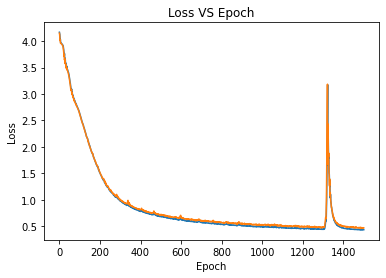

In [ ]:
plt.title('Loss VS Epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)
plt.plot(loss_arr_test)

In [ ]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_pred = model.forward(val)
        preds.append(y_pred.argmax().item())

In [ ]:
results2 = pd.DataFrame({'yActual': y_test, 'yPred': preds})
results2['Correct'] = [True if corr == pred else False for corr, pred in zip(results2['yActual'], results2['yPred'])]
results2['yActual_X_Coord'] = results2['yActual']//8
results2['yActual_Y_Coord'] = results2['yActual']%8
results2['yPred_X_Coord'] = results2['yPred']//8
results2['yPred_Y_Coord'] = results2['yPred']%8
results2['distance'] = ((results2['yActual_X_Coord'] - results2['yPred_X_Coord'])**2 + (results2['yActual_Y_Coord'] - results2['yPred_Y_Coord'])**2)**0.5
print(f"Accuracy: {results2['Correct'].sum() / len(results2)}")
print(f"Total distance: {results2['distance'].sum()}")
results2

Accuracy: 0.8423467946907653
Total distance: 8665.918281463904


,yActual,yPred,Correct,yActual_X_Coord,yActual_Y_Coord,yPred_X_Coord,yPred_Y_Coord,distance
0,32,24,False,4,0,3,0,1.000000
1,16,0,False,2,0,0,0,2.000000
2,63,63,True,7,7,7,7,0.000000
3,58,57,False,7,2,7,1,1.000000
4,1,1,True,0,1,0,1,0.000000
...,...,...,...,...,...,...,...,...
28323,57,19,False,7,1,2,3,5.385165
28324,53,53,True,6,5,6,5,0.000000
28325,63,63,True,7,7,7,7,0.000000
28326,35,35,True,4,3,4,3,0.000000


In [ ]:
mean_distances += [results2['distance'].mean()]
print(results2['distance'].mean())

0.3059135230677741


In [ ]:
# freezing layers
for param in model.parameters():
    param.requires_grad = False
model.fc1.weight.requires_grad = True
model.output.weight.requires_grad = True

In [ ]:
filename = '2.pt'
torch.save(model, PATH+filename)
model_2 = model

### Alternative ANN Classifier 3

In [ ]:
X_train, X_test, y_train, y_test = train_test_datasets['train']['X']['3'], train_test_datasets['test']['X']['3'], train_test_datasets['train']['y']['3'], train_test_datasets['test']['y']['3']

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(in_features=16, out_features=96)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=96, out_features=192)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(in_features=192, out_features=192)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(in_features=192, out_features=96)
        self.output = nn.Linear(in_features=96, out_features=64)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout1(x)
        x = F.gelu(self.fc2(x))
        x = self.dropout2(x)
        x = F.gelu(self.fc3(x))
        x = self.dropout3(x)
        x = F.gelu(self.fc4(x))
        x = self.output(x)
        return x
    
model = ANN()

In [ ]:
EPOCHS = 1500
L_R = 5e-3

In [ ]:
criterion = nn.CrossEntropyLoss() # choose this if classification
optimizer = torch.optim.Adam(model.parameters(), lr=L_R)

In [ ]:
loss_arr = []
loss_arr_test = []
last_loss = 100
patience = 8
trigger_times = 0
best_model = model
best_loss = 999

for i in range(0, EPOCHS+1):  
    y_pred = model.forward(X_train)
    
    loss_train = criterion(y_pred, y_train)
    loss_arr.append(loss_train.item())
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model.forward(X_test)
    loss = criterion(y_pred, y_test)
    loss_arr_test += [float(loss)]
    if loss_arr_test[-1] < best_loss:
        best_loss = loss_arr_test[-1]
        best_model = model
 
    if i%100 == 0:
        print(f'Epoch: {i} Train Loss: {loss_train} Test Loss: {loss_arr_test[-1]}')
    
    if loss > last_loss:
        trigger_times += 1

        if trigger_times > patience:
            print('Early stop!')
            break
    else:
        trigger_times = 0

    last_loss = loss

Epoch: 0 Train Loss: 4.160803318023682 Test Loss: 4.145758152008057
Epoch: 100 Train Loss: 2.697019100189209 Test Loss: 2.689868211746216
Epoch: 200 Train Loss: 1.4988560676574707 Test Loss: 1.5001980066299438
Epoch: 300 Train Loss: 0.9781963229179382 Test Loss: 0.9927490949630737
Epoch: 400 Train Loss: 0.7747904658317566 Test Loss: 0.7916169762611389
Epoch: 500 Train Loss: 0.6730478405952454 Test Loss: 0.6956060528755188
Epoch: 600 Train Loss: 0.5953208804130554 Test Loss: 0.6119137406349182
Epoch: 700 Train Loss: 0.5585916638374329 Test Loss: 0.5863267183303833
Epoch: 800 Train Loss: 0.5080729722976685 Test Loss: 0.5272789001464844
Epoch: 900 Train Loss: 0.4871737062931061 Test Loss: 0.5100882053375244
Epoch: 1000 Train Loss: 0.4665443003177643 Test Loss: 0.48696213960647583
Epoch: 1100 Train Loss: 0.44084280729293823 Test Loss: 0.46231186389923096
Epoch: 1200 Train Loss: 0.431917667388916 Test Loss: 0.4807027280330658
Epoch: 1300 Train Loss: 0.4221312403678894 Test Loss: 0.438414335

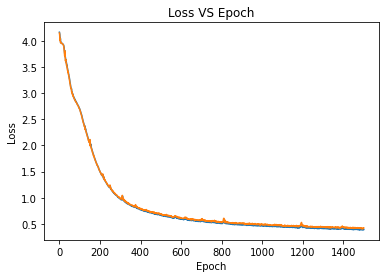

In [ ]:
plt.title('Loss VS Epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)
plt.plot(loss_arr_test)

In [ ]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_pred = model.forward(val)
        preds.append(y_pred.argmax().item())

In [ ]:
results3 = pd.DataFrame({'yActual': y_test, 'yPred': preds})
results3['Correct'] = [True if corr == pred else False for corr, pred in zip(results3['yActual'], results3['yPred'])]
results3['yActual_X_Coord'] = results3['yActual']//8
results3['yActual_Y_Coord'] = results3['yActual']%8
results3['yPred_X_Coord'] = results3['yPred']//8
results3['yPred_Y_Coord'] = results3['yPred']%8
results3['distance'] = ((results3['yActual_X_Coord'] - results3['yPred_X_Coord'])**2 + (results3['yActual_Y_Coord'] - results3['yPred_Y_Coord'])**2)**0.5
print(f"Accuracy: {results3['Correct'].sum() / len(results3)}")
print(f"Total distance: {results3['distance'].sum()}")
results3

Accuracy: 0.854419655464558
Total distance: 7999.252928181


,yActual,yPred,Correct,yActual_X_Coord,yActual_Y_Coord,yPred_X_Coord,yPred_Y_Coord,distance
0,59,59,True,7,3,7,3,0.000000
1,63,63,True,7,7,7,7,0.000000
2,27,27,True,3,3,3,3,0.000000
3,11,11,True,1,3,1,3,0.000000
4,29,29,True,3,5,3,5,0.000000
...,...,...,...,...,...,...,...,...
28323,43,43,True,5,3,5,3,0.000000
28324,57,57,True,7,1,7,1,0.000000
28325,27,27,True,3,3,3,3,0.000000
28326,24,24,True,3,0,3,0,0.000000


In [ ]:
mean_distances += [results3['distance'].mean()]
print(results3['distance'].mean())

0.28237972776690906


In [ ]:
# freezing layers
for param in model.parameters():
    param.requires_grad = False
model.fc1.weight.requires_grad = True
model.output.weight.requires_grad = True

In [ ]:
filename = '3.pt'
torch.save(model, PATH+filename)
model_3 = model

### Alternative ANN Classifier 4

In [ ]:
X_train, X_test, y_train, y_test = train_test_datasets['train']['X']['4'], train_test_datasets['test']['X']['4'], train_test_datasets['train']['y']['4'], train_test_datasets['test']['y']['4']

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(in_features=16, out_features=96)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=96, out_features=128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(in_features=128, out_features=192)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(in_features=192, out_features=256)
        self.output = nn.Linear(in_features=256, out_features=64)
        
    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = self.dropout1(x)
        x = F.silu(self.fc2(x))
        x = self.dropout2(x)
        x = F.silu(self.fc3(x))
        x = self.dropout3(x)
        x = F.silu(self.fc4(x))
        x = self.output(x)
        return x
    
model = ANN()

In [ ]:
EPOCHS = 1500
L_R = 5e-3

In [ ]:
criterion = nn.CrossEntropyLoss() # choose this if classification
optimizer = torch.optim.Adam(model.parameters(), lr=L_R)

In [ ]:
loss_arr = []
loss_arr_test = []
last_loss = 100
patience = 8
trigger_times = 0
best_model = model
best_loss = 999

for i in range(0, EPOCHS+1):  
    y_pred = model.forward(X_train)
    
    loss_train = criterion(y_pred, y_train)
    loss_arr.append(loss_train.item())
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model.forward(X_test)
    loss = criterion(y_pred, y_test)
    loss_arr_test += [float(loss)]
    if loss_arr_test[-1] < best_loss:
        best_loss = loss_arr_test[-1]
        best_model = model
 
    if i%100 == 0:
        print(f'Epoch: {i} Train Loss: {loss_train} Test Loss: {loss_arr_test[-1]}')
    
    if loss > last_loss:
        trigger_times += 1

        if trigger_times > patience:
            print('Early stop!')
            break
    else:
        trigger_times = 0

    last_loss = loss

Epoch: 0 Train Loss: 4.15962553024292 Test Loss: 4.134644508361816
Epoch: 100 Train Loss: 2.6179378032684326 Test Loss: 2.611952304840088
Epoch: 200 Train Loss: 1.6437301635742188 Test Loss: 1.647801399230957
Epoch: 300 Train Loss: 0.9050193428993225 Test Loss: 0.9189492464065552
Epoch: 400 Train Loss: 0.6344919204711914 Test Loss: 0.6575934290885925
Epoch: 500 Train Loss: 0.5122932195663452 Test Loss: 0.5241630673408508
Epoch: 600 Train Loss: 0.4419657289981842 Test Loss: 0.4696226716041565
Epoch: 700 Train Loss: 0.3970198929309845 Test Loss: 0.4236961901187897
Epoch: 800 Train Loss: 0.3684540092945099 Test Loss: 0.3935723602771759
Epoch: 900 Train Loss: 0.35056358575820923 Test Loss: 0.37566348910331726
Early stop!


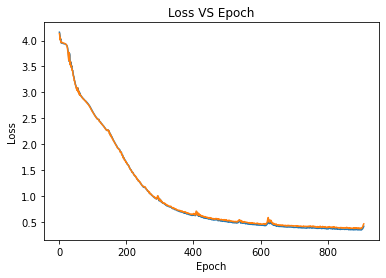

In [ ]:
plt.title('Loss VS Epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)
plt.plot(loss_arr_test)

In [ ]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_pred = model.forward(val)
        preds.append(y_pred.argmax().item())

In [ ]:
results4 = pd.DataFrame({'yActual': y_test, 'yPred': preds})
results4['Correct'] = [True if corr == pred else False for corr, pred in zip(results4['yActual'], results4['yPred'])]
results4['yActual_X_Coord'] = results4['yActual']//8
results4['yActual_Y_Coord'] = results4['yActual']%8
results4['yPred_X_Coord'] = results4['yPred']//8
results4['yPred_Y_Coord'] = results4['yPred']%8
results4['distance'] = ((results4['yActual_X_Coord'] - results4['yPred_X_Coord'])**2 + (results4['yActual_Y_Coord'] - results4['yPred_Y_Coord'])**2)**0.5
print(f"Accuracy: {results4['Correct'].sum() / len(results4)}")
print(f"Total distance: {results4['distance'].sum()}")
results4

Accuracy: 0.8393462298785653
Total distance: 9049.94084442315


,yActual,yPred,Correct,yActual_X_Coord,yActual_Y_Coord,yPred_X_Coord,yPred_Y_Coord,distance
0,28,28,True,3,4,3,4,0.0
1,48,48,True,6,0,6,0,0.0
2,35,27,False,4,3,3,3,1.0
3,54,54,True,6,6,6,6,0.0
4,47,47,True,5,7,5,7,0.0
...,...,...,...,...,...,...,...,...
28323,39,39,True,4,7,4,7,0.0
28324,53,53,True,6,5,6,5,0.0
28325,29,29,True,3,5,3,5,0.0
28326,48,48,True,6,0,6,0,0.0


In [ ]:
mean_distances += [results4['distance'].mean()]
print(results4['distance'].mean())

0.31946981235608407


In [ ]:
# freezing layers
for param in model.parameters():
    param.requires_grad = False
model.fc1.weight.requires_grad = True
model.output.weight.requires_grad = True

In [ ]:
filename = '4.pt'
torch.save(model, PATH+filename)
model_4 = model

### Alternative ANN Classifier 5

In [ ]:
X_train, X_test, y_train, y_test = train_test_datasets['train']['X']['5'], train_test_datasets['test']['X']['5'], train_test_datasets['train']['y']['5'], train_test_datasets['test']['y']['5']

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(in_features=16, out_features=96)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=96, out_features=160)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(in_features=160, out_features=192)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(in_features=192, out_features=256)
        self.output = nn.Linear(in_features=256, out_features=64)
        
    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = self.dropout1(x)
        x = F.silu(self.fc2(x))
        x = self.dropout2(x)
        x = F.silu(self.fc3(x))
        x = self.dropout3(x)
        x = F.silu(self.fc4(x))
        x = self.output(x)
        return x
    
model = ANN()

In [ ]:
EPOCHS = 1500
L_R = 5e-3

In [ ]:
criterion = nn.CrossEntropyLoss() # choose this if classification
optimizer = torch.optim.Adam(model.parameters(), lr=L_R)

In [ ]:
loss_arr = []
loss_arr_test = []
last_loss = 100
patience = 8
trigger_times = 0
best_model = model
best_loss = 999

for i in range(0, EPOCHS+1):  
    y_pred = model.forward(X_train)
    
    loss_train = criterion(y_pred, y_train)
    loss_arr.append(loss_train.item())
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model.forward(X_test)
    loss = criterion(y_pred, y_test)
    loss_arr_test += [float(loss)]
    if loss_arr_test[-1] < best_loss:
        best_loss = loss_arr_test[-1]
        best_model = model
 
    if i%100 == 0:
        print(f'Epoch: {i} Train Loss: {loss_train} Test Loss: {loss_arr_test[-1]}')
    
    if loss > last_loss:
        trigger_times += 1

        if trigger_times > patience:
            print('Early stop!')
            break
    else:
        trigger_times = 0

    last_loss = loss

Epoch: 0 Train Loss: 4.156650066375732 Test Loss: 4.129676818847656
Epoch: 100 Train Loss: 2.5554354190826416 Test Loss: 2.551555633544922
Epoch: 200 Train Loss: 1.4067790508270264 Test Loss: 1.428897738456726
Epoch: 300 Train Loss: 0.8050886988639832 Test Loss: 0.8289214372634888
Epoch: 400 Train Loss: 0.5701755881309509 Test Loss: 0.5949786901473999
Epoch: 500 Train Loss: 0.4663632810115814 Test Loss: 0.4930199384689331
Epoch: 600 Train Loss: 0.4132690131664276 Test Loss: 0.43659117817878723
Epoch: 700 Train Loss: 1.008823275566101 Test Loss: 1.0102771520614624
Epoch: 800 Train Loss: 0.4246894121170044 Test Loss: 0.4505227208137512
Epoch: 900 Train Loss: 0.37434056401252747 Test Loss: 0.4075039327144623
Epoch: 1000 Train Loss: 0.3536045551300049 Test Loss: 0.3845334053039551
Epoch: 1100 Train Loss: 0.33867740631103516 Test Loss: 0.36900708079338074
Epoch: 1200 Train Loss: 0.32644036412239075 Test Loss: 0.3471653461456299
Epoch: 1300 Train Loss: 0.3170098066329956 Test Loss: 0.3396311

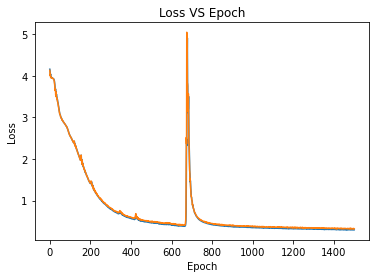

In [ ]:
plt.title('Loss VS Epoch')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)
plt.plot(loss_arr_test)

In [ ]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_pred = model.forward(val)
        preds.append(y_pred.argmax().item())

In [ ]:
results5 = pd.DataFrame({'yActual': y_test, 'yPred': preds})
results5['Correct'] = [True if corr == pred else False for corr, pred in zip(results5['yActual'], results5['yPred'])]
results5['yActual_X_Coord'] = results5['yActual']//8
results5['yActual_Y_Coord'] = results5['yActual']%8
results5['yPred_X_Coord'] = results5['yPred']//8
results5['yPred_Y_Coord'] = results5['yPred']%8
results5['distance'] = ((results5['yActual_X_Coord'] - results5['yPred_X_Coord'])**2 + (results5['yActual_Y_Coord'] - results5['yPred_Y_Coord'])**2)**0.5
print(f"Accuracy: {results5['Correct'].sum() / len(results5)}")
print(f"Total distance: {results5['distance'].sum()}")
results5

Accuracy: 0.8854449818194655
Total distance: 6102.7431748191775


,yActual,yPred,Correct,yActual_X_Coord,yActual_Y_Coord,yPred_X_Coord,yPred_Y_Coord,distance
0,20,20,True,2,4,2,4,0.000000
1,59,59,True,7,3,7,3,0.000000
2,52,52,True,6,4,6,4,0.000000
3,29,38,False,3,5,4,6,1.414214
4,28,28,True,3,4,3,4,0.000000
...,...,...,...,...,...,...,...,...
28322,44,44,True,5,4,5,4,0.000000
28323,36,36,True,4,4,4,4,0.000000
28324,28,28,True,3,4,3,4,0.000000
28325,20,20,True,2,4,2,4,0.000000


In [ ]:
mean_distances += [results5['distance'].mean()]
print(results5['distance'].mean())

0.21543909255548338


In [ ]:
# freezing layers
for param in model.parameters():
    param.requires_grad = False
model.fc1.weight.requires_grad = True
model.output.weight.requires_grad = True

In [ ]:
filename = '5.pt'
torch.save(model, PATH+filename)
model_5 = model

# Ensembling with ANN

In [ ]:
# model_1 = torch.jit.load('1.pt')
# model_2 = torch.jit.load('2.pt')
# model_3 = torch.jit.load('3.pt')
# model_4 = torch.jit.load('4.pt')
# model_5 = torch.jit.load('5.pt')

In [ ]:
model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()
model_5.eval()

RecursiveScriptModule(
  original_name=ANN
  (fc1): RecursiveScriptModule(original_name=Linear)
  (dropout1): RecursiveScriptModule(original_name=Dropout)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (dropout2): RecursiveScriptModule(original_name=Dropout)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (dropout3): RecursiveScriptModule(original_name=Dropout)
  (fc4): RecursiveScriptModule(original_name=Linear)
  (output): RecursiveScriptModule(original_name=Linear)
)

In [ ]:
MIN = 0
MAX = 7

In [ ]:
# testing base model accuracy
results = pd.DataFrame({'X_val': y_val//8, 'Y_val': y_val%8})
for index, trained_model in enumerate([model_1, model_2, model_3, model_4, model_5], 1):
    preds = []
    with torch.no_grad():
        for val in X_val:
            y_pred = trained_model.forward(val)
            preds.append(y_pred.argmax().item())
    preds_X_Coord = [i//8 for i in preds]
    preds_Y_Coord = [i%8 for i in preds]
    results['X'+str(index)] = preds_X_Coord
    results['Y'+str(index)] = preds_Y_Coord
results

,X_val,Y_val,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5
0,0,3,0,3,0,3,0,3,0,3,0,3
1,6,5,6,5,6,5,6,5,7,7,6,5
2,6,5,6,5,6,5,6,5,6,5,6,5
3,6,5,6,5,6,5,6,5,6,5,6,5
4,0,7,0,7,0,7,0,7,0,7,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
7450,1,3,1,3,1,3,1,3,1,3,1,3
7451,4,4,4,4,4,4,4,4,4,4,4,4
7452,5,2,5,2,5,2,5,2,5,2,5,2
7453,7,7,7,7,7,7,7,7,7,7,7,7


In [ ]:
def getAccuracy(data, which_x, which_y):
    total = len(data)
    return round(len(data[data['X_val']==data[which_x]][data['Y_val']==data[which_y]])/total*100, 2)
print(f"Accuracy of model 1: {getAccuracy(results, 'X1', 'Y1')}%")
print(f"Accuracy of model 2: {getAccuracy(results, 'X2', 'Y2')}%")
print(f"Accuracy of model 3: {getAccuracy(results, 'X3', 'Y3')}%")
print(f"Accuracy of model 4: {getAccuracy(results, 'X4', 'Y4')}%")
print(f"Accuracy of model 5: {getAccuracy(results, 'X5', 'Y5')}%")

Accuracy of model 1: 95.61%
Accuracy of model 2: 92.74%
Accuracy of model 3: 93.78%
Accuracy of model 4: 92.58%
Accuracy of model 5: 95.73%


In [ ]:
### average ensemble - get mean and then round off to nearest integer
avg_ensemble = results.copy(deep=True)
avg_ensemble['X_pred'] = (avg_ensemble['X1'] + avg_ensemble['X2'] + avg_ensemble['X3'] + avg_ensemble['X4'] + avg_ensemble['X5'])/5
avg_ensemble['Y_pred'] = (avg_ensemble['Y1'] + avg_ensemble['Y2'] + avg_ensemble['Y3'] + avg_ensemble['Y4'] + avg_ensemble['Y5'])/5
avg_ensemble = avg_ensemble.drop(['X1', 'X2', 'X3', 'X4', 'X5', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5'], axis=1)
avg_ensemble = avg_ensemble.round()
avg_ensemble = avg_ensemble.astype('int')
print(f"Accuracy of average-ensemble: {getAccuracy(avg_ensemble, 'X_pred', 'Y_pred')}%")
avg_ensemble

Accuracy of average-ensemble: 93.87%


,X_val,Y_val,X_pred,Y_pred
0,0,3,0,3
1,6,5,6,5
2,6,5,6,5
3,6,5,6,5
4,0,7,0,7
...,...,...,...,...
7450,1,3,1,3
7451,4,4,4,4
7452,5,2,5,2
7453,7,7,7,7


In [ ]:
### hard voting ensemble - get mean and then round off to nearest integer
hard_ensemble = results.copy(deep=True)
hard_ensemble_X = hard_ensemble[['X1', 'X2', 'X3', 'X4', 'X5']]
hard_ensemble_Y = hard_ensemble[['Y1', 'Y2', 'Y3', 'Y4', 'Y5']]
hard_ensemble_X = hard_ensemble_X.mode(axis=1)
hard_ensemble_Y = hard_ensemble_Y.mode(axis=1)
hard_ensemble = hard_ensemble.drop(['X1', 'X2', 'X3', 'X4', 'X5', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5'], axis=1)
hard_ensemble['X_pred'] = hard_ensemble_X[0]
hard_ensemble['Y_pred'] = hard_ensemble_Y[0]
hard_ensemble = hard_ensemble.astype('int')
print(f"Accuracy of hard-voting ensemble: {getAccuracy(hard_ensemble, 'X_pred', 'Y_pred')}%")
hard_ensemble

Accuracy of hard-voting ensemble: 95.16%


,X_val,Y_val,X_pred,Y_pred
0,0,3,0,3
1,6,5,6,5
2,6,5,6,5
3,6,5,6,5
4,0,7,0,7
...,...,...,...,...
7450,1,3,1,3
7451,4,4,4,4
7452,5,2,5,2
7453,7,7,7,7


In [ ]:
### modified hard voting ensemble - preferentially choose the results from top-voted model in tied votes
mod_ensemble = results.copy(deep=True)
mod_ensemble_X = mod_ensemble[['X1', 'X2', 'X3', 'X4', 'X5']]
mod_ensemble_Y = mod_ensemble[['Y1', 'Y2', 'Y3', 'Y4', 'Y5']]
mod_ensemble_X = mod_ensemble_X.mode(axis=1)
mod_ensemble_Y = mod_ensemble_Y.mode(axis=1)
mod_ensemble = mod_ensemble.drop(['X1', 'X2', 'X3', 'X4', 'X5', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5'], axis=1)
mod_ensemble_X.loc[mod_ensemble_X[1].notna(), 0] = results[mod_ensemble_X[1].notna()]['X5']
mod_ensemble_Y.loc[mod_ensemble_Y[1].notna(), 0] = results[mod_ensemble_Y[1].notna()]['Y5']
mod_ensemble['X_pred'] = mod_ensemble_X[0]
mod_ensemble['Y_pred'] = mod_ensemble_Y[0]
mod_ensemble['X_pred'] = pd.to_numeric(mod_ensemble['X_pred'], errors='coerce').fillna(0).astype(int)
mod_ensemble['Y_pred'] = pd.to_numeric(mod_ensemble['Y_pred'], errors='coerce').fillna(0).astype(int)
print(f"Accuracy of modified hard-voting ensemble: {getAccuracy(mod_ensemble, 'X_pred', 'Y_pred')}%")
mod_ensemble

Accuracy of modified hard-voting ensemble: 95.14%


,X_val,Y_val,X_pred,Y_pred
0,0,3,0,3
1,6,5,6,5
2,6,5,6,5
3,6,5,6,5
4,0,7,0,7
...,...,...,...,...
7450,1,3,1,3
7451,4,4,4,4
7452,5,2,5,2
7453,7,7,7,7


In [ ]:
### soft voting ensemble - choose the argmax of the sum of predicted Tensors
soft_ensemble = pd.DataFrame({'X_val': y_val//8, 'Y_val': y_val%8})
preds = []
with torch.no_grad():
    for val in X_val:
        y_pred = model_1.forward(val)
        for trained_model in [model_2, model_3, model_4, model_5]:
            y_pred += trained_model.forward(val)
        preds.append(y_pred.argmax().item())
preds_X_Coord = [i//8 for i in preds]
preds_Y_Coord = [i%8 for i in preds]
soft_ensemble['X_pred'] = preds_X_Coord
soft_ensemble['Y_pred'] = preds_Y_Coord
print(f"Accuracy of soft-voting ensemble: {getAccuracy(soft_ensemble, 'X_pred', 'Y_pred')}%")
soft_ensemble

Accuracy of soft-voting ensemble: 95.95%


,X_val,Y_val,X_pred,Y_pred
0,0,3,0,3
1,6,5,6,5
2,6,5,6,5
3,6,5,6,5
4,0,7,0,7
...,...,...,...,...
7450,1,3,1,3
7451,4,4,4,4
7452,5,2,5,2
7453,7,7,7,7


In [ ]:
y_val

115148    0,3
144458    6,5
20633     6,5
5330      6,5
91127     0,7
         ... 
89073     1,3
106413    4,4
143864    5,2
55425     7,7
131687    4,0
Name: XY, Length: 7455, dtype: object

#### Conclusion: The use of differently trained ANN models (to reduce correlation) to create an ensemble proves fruitful - it can be observed that there exist some errors that can be picked up by certain ANN models but missed by others. Ensembling helps to combine the mapping functions learned by each and every contributing ANN, thereby probabilistically reducing the chances of choosing the incorrect prediction if some of the models predicted correctly. Soft-voting ensemble proves to be quite straighforward and the most effective of the ensemble methods.

# Summary

In [ ]:
results['distance'] = ((results['X_val'] - results['X1'])**2 + (results['Y_val'] - results['Y1'])**2)**0.5
print(f"Total distance for model 1 is {round(results['distance'].sum(), 2)} and mean distance is {round(results['distance'].mean(), 3)}m (against total)/{round(results[results['distance']>0]['distance'].mean(), 3)}m (against incorrect)")
results['distance'] = ((results['X_val'] - results['X2'])**2 + (results['Y_val'] - results['Y2'])**2)**0.5
print(f"Total distance for model 2 is {round(results['distance'].sum(), 2)} and mean distance is {round(results['distance'].mean(), 3)}m (against total)/{round(results[results['distance']>0]['distance'].mean(), 3)}m (against incorrect)")
results['distance'] = ((results['X_val'] - results['X3'])**2 + (results['Y_val'] - results['Y3'])**2)**0.5
print(f"Total distance for model 3 is {round(results['distance'].sum(), 2)} and mean distance is {round(results['distance'].mean(), 3)}m (against total)/{round(results[results['distance']>0]['distance'].mean(), 3)}m (against incorrect)")
results['distance'] = ((results['X_val'] - results['X4'])**2 + (results['Y_val'] - results['Y4'])**2)**0.5
print(f"Total distance for model 4 is {round(results['distance'].sum(), 2)} and mean distance is {round(results['distance'].mean(), 3)}m (against total)/{round(results[results['distance']>0]['distance'].mean(), 3)}m (against incorrect)")
results['distance'] = ((results['X_val'] - results['X5'])**2 + (results['Y_val'] - results['Y5'])**2)**0.5
print(f"Total distance for model 5 is {round(results['distance'].sum(), 2)} and mean distance is {round(results['distance'].mean(), 3)}m (against total)/{round(results[results['distance']>0]['distance'].mean(), 3)}m (against incorrect)")
results['distance'] = ((avg_ensemble['X_val'] - avg_ensemble['X_pred'])**2 + (avg_ensemble['Y_val'] - avg_ensemble['Y_pred'])**2)**0.5
print(f"Total distance for average ensemble is {round(results['distance'].sum(), 2)} and mean distance is {round(results['distance'].mean(), 3)}m (against total)/{round(results[results['distance']>0]['distance'].mean(), 3)}m (against incorrect)")
results['distance'] = ((hard_ensemble['X_val'] - hard_ensemble['X_pred'])**2 + (hard_ensemble['Y_val'] - hard_ensemble['Y_pred'])**2)**0.5
print(f"Total distance for hard-voting ensemble is {round(results['distance'].sum(), 2)} and mean distance is {round(results['distance'].mean(), 3)}m (against total)/{round(results[results['distance']>0]['distance'].mean(), 3)}m (against incorrect)")
results['distance'] = ((mod_ensemble['X_val'] - mod_ensemble['X_pred'])**2 + (mod_ensemble['Y_val'] - mod_ensemble['Y_pred'])**2)**0.5
print(f"Total distance for modified hard-voting ensemble is {round(results['distance'].sum(), 2)} and mean distance is {round(results['distance'].mean(), 3)}m (against total)/{round(results[results['distance']>0]['distance'].mean(), 3)}m (against incorrect)")
results['distance'] = ((soft_ensemble['X_val'] - soft_ensemble['X_pred'])**2 + (soft_ensemble['Y_val'] - soft_ensemble['Y_pred'])**2)**0.5
print(f"Total distance for soft-voting ensemble is {round(results['distance'].sum(), 2)} and mean distance is {round(results['distance'].mean(), 3)}m (against total)/{round(results[results['distance']>0]['distance'].mean(), 3)}m (against incorrect)")
results = results.drop(['distance'], axis=1)

Total distance for model 1 is 521.54 and mean distance is 0.07m (against total)/1.595m (against incorrect)
Total distance for model 2 is 839.47 and mean distance is 0.113m (against total)/1.552m (against incorrect)
Total distance for model 3 is 737.81 and mean distance is 0.099m (against total)/1.59m (against incorrect)
Total distance for model 4 is 878.26 and mean distance is 0.118m (against total)/1.588m (against incorrect)
Total distance for model 5 is 504.58 and mean distance is 0.068m (against total)/1.587m (against incorrect)
Total distance for average ensemble is 611.52 and mean distance is 0.082m (against total)/1.338m (against incorrect)
Total distance for hard-voting ensemble is 562.77 and mean distance is 0.075m (against total)/1.559m (against incorrect)
Total distance for modified hard-voting ensemble is 559.89 and mean distance is 0.075m (against total)/1.547m (against incorrect)
Total distance for soft-voting ensemble is 472.69 and mean distance is 0.063m (against total)/

In [ ]:
plot_data = pd.DataFrame()
plot_data['Model 1'] = (results['X_val'] == results['X1'])&(results['Y_val'] == results['Y1'])
plot_data['Model 2'] = (results['X_val'] == results['X2'])&(results['Y_val'] == results['Y2'])
plot_data['Model 3'] = (results['X_val'] == results['X3'])&(results['Y_val'] == results['Y3'])
plot_data['Model 4'] = (results['X_val'] == results['X4'])&(results['Y_val'] == results['Y4'])
plot_data['Model 5'] = (results['X_val'] == results['X5'])&(results['Y_val'] == results['Y5'])
plot_data

,Model 1,Model 2,Model 3,Model 4,Model 5
0,True,True,True,True,True
1,True,True,True,False,True
2,True,True,True,True,True
3,True,True,True,True,True
4,True,True,True,True,True
...,...,...,...,...,...
7450,True,True,True,True,True
7451,True,True,True,True,True
7452,True,True,True,True,True
7453,True,True,True,True,True


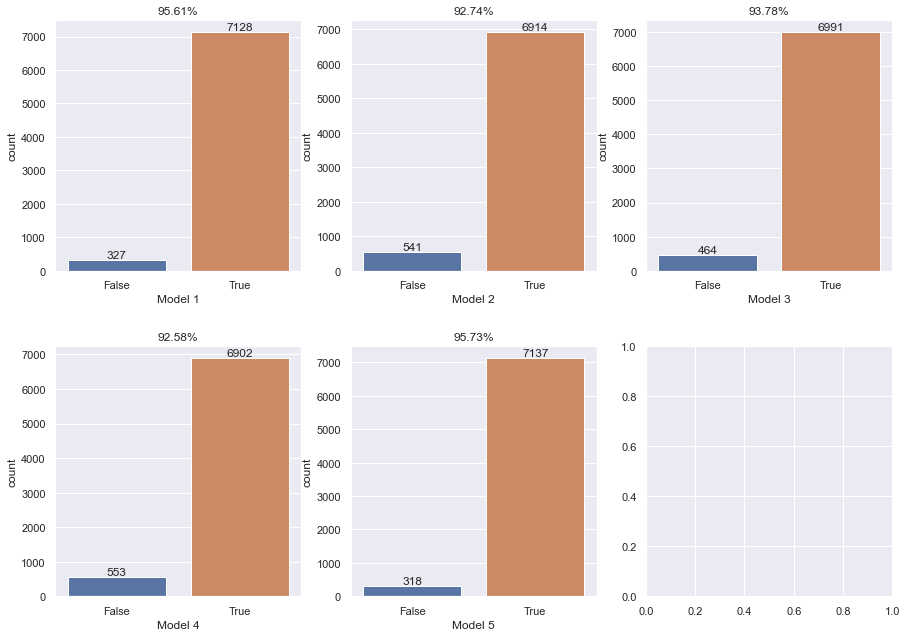

In [ ]:
fig, ax = plt.subplots(2,3)
fig.set_figheight(20)
fig.set_figwidth(15)
a = sns.countplot(data=plot_data, x='Model 1', ax=ax[0,0])
a.bar_label(a.containers[0])
a.set(title=f"{getAccuracy(results, 'X1', 'Y1')}%")
b = sns.countplot(data=plot_data, x='Model 2', ax=ax[0,1])
b.bar_label(b.containers[0])
b.set(title=f"{getAccuracy(results, 'X2', 'Y2')}%")
c = sns.countplot(data=plot_data, x='Model 3', ax=ax[0,2])
c.bar_label(c.containers[0])
c.set(title=f"{getAccuracy(results, 'X3', 'Y3')}%")
d = sns.countplot(data=plot_data, x='Model 4', ax=ax[1,0])
d.bar_label(d.containers[0])
d.set(title=f"{getAccuracy(results, 'X4', 'Y4')}%")
e = sns.countplot(data=plot_data, x='Model 5', ax=ax[1,1])
e.bar_label(e.containers[0])
e.set(title=f"{getAccuracy(results, 'X5', 'Y5')}%")
        
plt.subplots_adjust(bottom=0.1, top=0.5, hspace=0.3)
plt.show()

In [ ]:
plot_data = pd.DataFrame()
plot_data['XY'] = results['X_val'].astype(str) + ', ' + results['Y_val'].astype(str)
plot_data['Model 1'] = ((results['X_val'] - results['X1'])**2 + (results['Y_val'] - results['Y1'])**2)**0.5
plot_data['Model 2'] = ((results['X_val'] - results['X2'])**2 + (results['Y_val'] - results['Y2'])**2)**0.5
plot_data['Model 3'] = ((results['X_val'] - results['X3'])**2 + (results['Y_val'] - results['Y3'])**2)**0.5
plot_data['Model 4'] = ((results['X_val'] - results['X4'])**2 + (results['Y_val'] - results['Y4'])**2)**0.5
plot_data['Model 5'] = ((results['X_val'] - results['X5'])**2 + (results['Y_val'] - results['Y5'])**2)**0.5
plot_data

,XY,Model 1,Model 2,Model 3,Model 4,Model 5
0,"0, 3",0.0,0.0,0.0,0.000000,0.0
1,"6, 5",0.0,0.0,0.0,2.236068,0.0
2,"6, 5",0.0,0.0,0.0,0.000000,0.0
3,"6, 5",0.0,0.0,0.0,0.000000,0.0
4,"0, 7",0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...
7450,"1, 3",0.0,0.0,0.0,0.000000,0.0
7451,"4, 4",0.0,0.0,0.0,0.000000,0.0
7452,"5, 2",0.0,0.0,0.0,0.000000,0.0
7453,"7, 7",0.0,0.0,0.0,0.000000,0.0


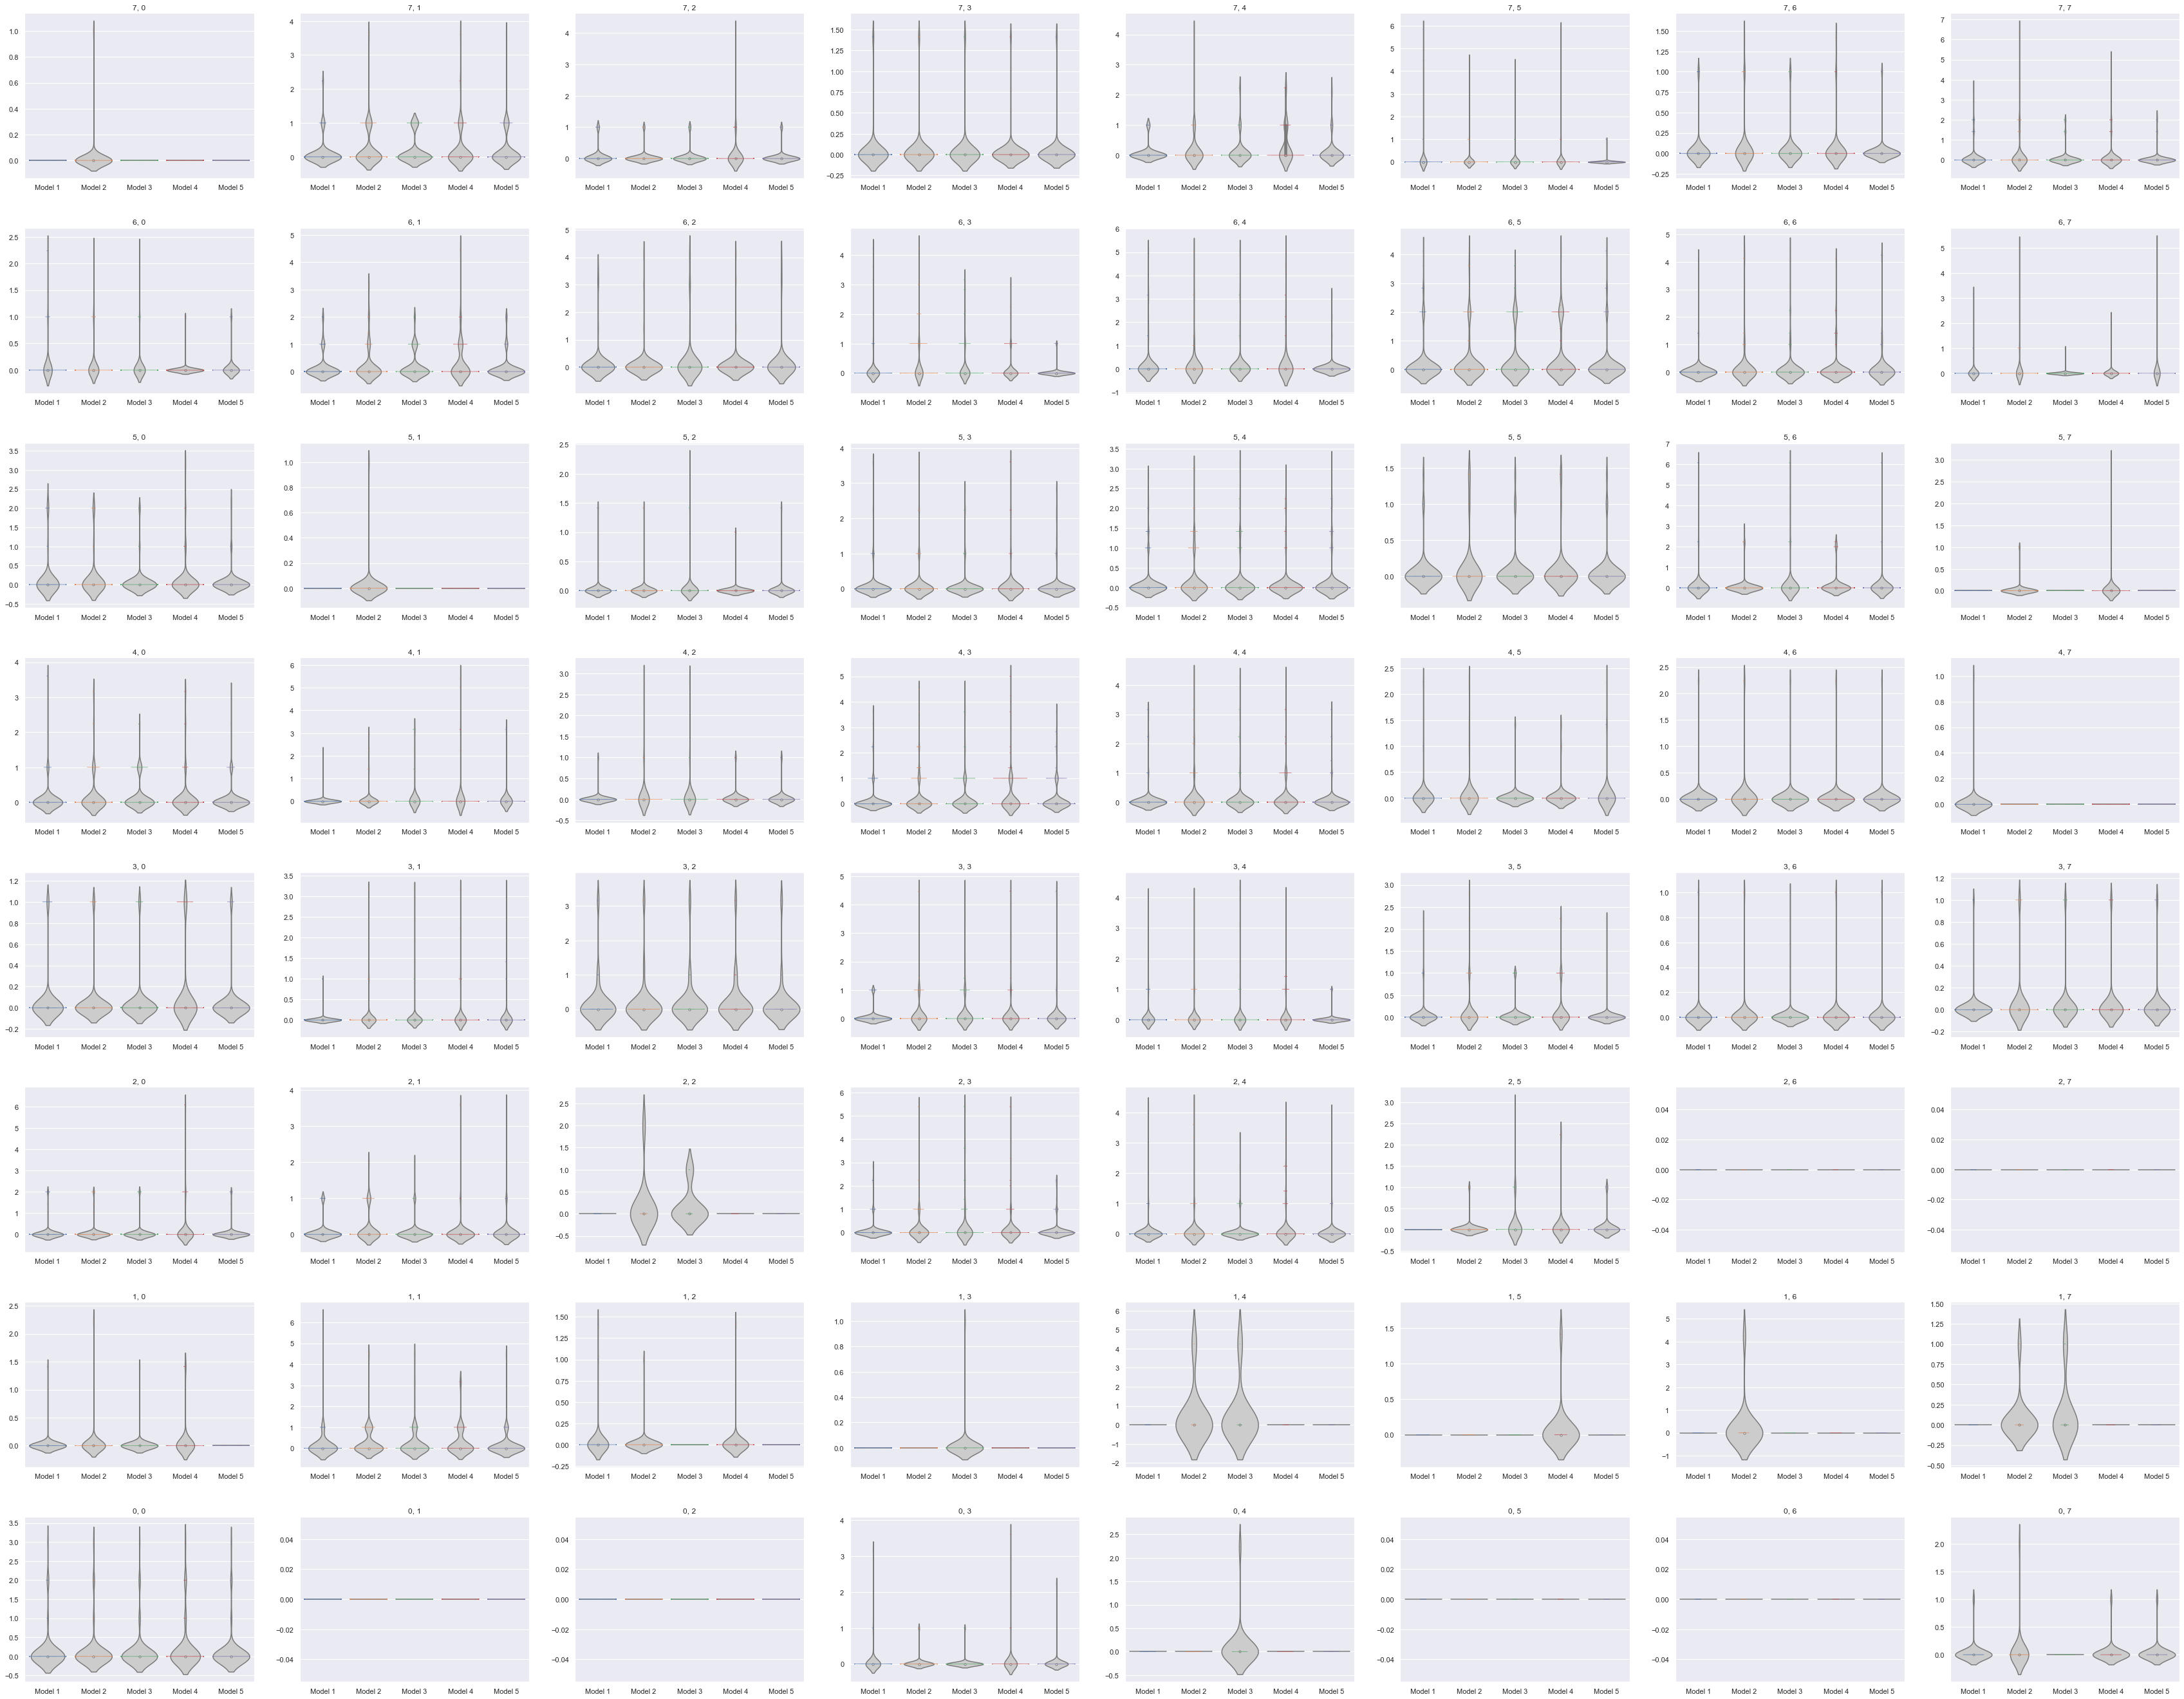

In [ ]:
fig, ax = plt.subplots(8,8)
fig.set_figheight(40)
fig.set_figwidth(60)
for x in range(8):
    for y in range(8):
        selection = plot_data[plot_data['XY']==str(x)+', '+str(y)]
        sns.violinplot(data=selection, color="0.8", ax=ax[7-x,y])
#         sns.boxplot(data=selection, ax=ax[7-x,y])
        sns.swarmplot(data=selection, size=1, ax=ax[7-x,y]).set(title=str(x)+', '+str(y))
plt.subplots_adjust(bottom=0.1, top=1, hspace=0.3)
plt.show()

# Appendix (Useful utilities)

In [ ]:
# visualisation helper
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(mod_ensemble_X[mod_ensemble_X[1].notna()])

In [ ]:
# converting to TorchScript helper (for easier imports once finalised)
model_1 = torch.jit.script(model_1)
model_2 = torch.jit.script(model_2)
model_3 = torch.jit.script(model_3)
model_4 = torch.jit.script(model_4)
model_5 = torch.jit.script(model_5)
model_1.save('1.pt')
model_2.save('2.pt')
model_3.save('3.pt')
model_4.save('4.pt')
model_5.save('5.pt')